# MediaPipe EyeBlink Detection

## Configuration

In [ ]:
!wget -O configure.sh 'https://raw.githubusercontent.com/sawthiha/mp_proctor/master/eval/configure.sh'
!chmod +x configure.sh
!./configure.sh

## Dependencies

In [ ]:
!pip install mediapipe

import mediapipe as mp
import cv2
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn.metrics as metrics

import statsmodels.formula.api as smf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Constant and Helpers

In [ ]:
landmark_indices = [
    # left_iris
    469, 470,
    471, 472,
    
    # right iris
    474, 475,
    476, 477,

    # nose
    1,

    # left eye, right to left
    158, 159, 160,
    153, 145, 144,
    # left eye left - right
    33, 133, 

    # right eye, right to left
    387, 386, 385,
    373, 374, 380,
    # right eye left - right
    362, 263
]
coor_columns = [item for sublist in [(f'{idx}_x', f'{idx}_y') for idx in landmark_indices] for item in sublist]

In [ ]:
def read_blink_df(id: int) -> pd.DataFrame:
  blink_df = pd.read_csv(f'dataset/rt_bene/raw/s{id:03}_noglasses/blink_labels.csv', names=['image', 'is_blinking'])
  blink_df.image = blink_df.image.str.replace('left', f'dataset/rt_bene/raw/s{id:03}_noglasses/natural/face/face')
  return blink_df

In [ ]:
def infer_static_images(images, callback):
  N_IMAGES = len(images)
  na_idx = []
  mp_face_mesh = mp.solutions.face_mesh
  with mp_face_mesh.FaceMesh(
      static_image_mode=True,
      max_num_faces=1,
      refine_landmarks=True,
      min_detection_confidence=0.5) as face_mesh:
    for idx, file in enumerate(images):
      print(f'{idx / N_IMAGES * 100}% analyzed', end = '\r')
      image = cv2.imread(file)
      # Convert the BGR image to RGB before processing.
      try:
        res = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      except:
        na_idx.append(idx)
        print(f'Exception occured while processing {file} at index {idx}')
        continue
      
      # Print and draw face mesh landmarks on the image.
      if not res.multi_face_landmarks:
        na_idx.append(idx)
        continue
      callback(idx, image, res.multi_face_landmarks)     
  return na_idx

def record_coor_df_decorator(coor_df):
  def wrapper(idx, image, multi_face_landmarks):
    for face_landmarks in multi_face_landmarks:
        ls = face_landmarks
        xs = [landmark.x for landmark in face_landmarks.landmark]
        ys = [landmark.y for landmark in face_landmarks.landmark]
        zs = [landmark.z for landmark in face_landmarks.landmark]
        xs = np.array(xs)
        ys = np.array(ys)
        zs = np.array(zs)
        std_xs = (xs - xs.mean()) / xs.std()
        std_ys = (ys - ys.mean()) / ys.std()
        std_zs = (zs - zs.mean()) / zs.std()

        for lm_idx in landmark_indices:
          coor_df.loc[idx, f'{lm_idx}_x'] = std_xs[lm_idx]
          coor_df.loc[idx, f'{lm_idx}_y'] = std_ys[lm_idx]
  return wrapper

def record_candid_coor_df_decorator(coor_df):
  def wrapper(idx, image, multi_face_landmarks):
    width = image.shape[0]
    height = image.shape[1]
    for face_landmarks in multi_face_landmarks:
        ls = face_landmarks
        xs = [landmark.x for landmark in face_landmarks.landmark]
        ys = [landmark.y for landmark in face_landmarks.landmark]
        zs = [landmark.z for landmark in face_landmarks.landmark]
        xs = np.array(xs)
        ys = np.array(ys)
        zs = np.array(zs)
        candid_xs = xs * width
        candid_ys = ys * height
        candid_zs = zs

        for lm_idx in landmark_indices:
          coor_df.loc[idx, f'{lm_idx}_x'] = candid_xs[lm_idx]
          coor_df.loc[idx, f'{lm_idx}_y'] = candid_ys[lm_idx]
  return wrapper

def annotate_static_images(images, callback):
  mp_drawing = mp.solutions.drawing_utils
  mp_drawing_styles = mp.solutions.drawing_styles
  mp_face_mesh = mp.solutions.face_mesh

  # For static images:
  IMAGE_FILES = images
  blinks = []
  with mp_face_mesh.FaceMesh(
      static_image_mode=True,
      max_num_faces=1,
      refine_landmarks=True,
      min_detection_confidence=0.5) as face_mesh:
    for idx, file in enumerate(IMAGE_FILES):
      image = cv2.imread(file)
      # Convert the BGR image to RGB before processing.
      results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      # Print and draw face mesh landmarks on the image.
      if not results.multi_face_landmarks:
        continue
      annotated_image = image.copy()
      for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_iris_connections_style())
      callback(idx, annotated_image)

## Prepare Training Data

### Standardized Landmarks

In [ ]:
train_blink_df = pd.concat(
    [read_blink_df(id) for id in range(14)], ignore_index=True
)

train_coor_df = pd.DataFrame(
    data = {
        col: np.zeros(train_blink_df.shape[0])
        for col in coor_columns
    }
)

na_idx = infer_static_images(train_blink_df.image.to_list(), record_coor_df_decorator(train_coor_df))
train_blink_df[train_coor_df.columns] = train_coor_df
train_blink_df = train_blink_df.drop(train_blink_df.index[na_idx])
train_blink_df.to_csv('train_rtbene_coors.csv')

### Raw Landmarks

In [ ]:
train_blink_df = pd.concat(
    [read_blink_df(id) for id in range(14)], ignore_index=True
)

train_coor_df = pd.DataFrame(
    data = {
        col: np.zeros(train_blink_df.shape[0])
        for col in coor_columns
    }, 
)

na_idx = infer_static_images(train_blink_df.image.to_list(), record_candid_coor_df_decorator(train_coor_df))
train_blink_df[train_coor_df.columns] = train_coor_df
train_blink_df = train_blink_df.drop(train_blink_df.index[na_idx])
train_blink_df.to_csv('train_rtbene_candid_coors.csv')

## Prepare Evaluation Data

### Standardized Landmarks

In [ ]:
eval_blink_df = pd.concat(
    [read_blink_df(id) for id in range(14, 17)], ignore_index=True
)
eval_coor_df = pd.DataFrame(
    data = {
        col: np.zeros(eval_blink_df.shape[0])
        for col in coor_columns
    }, 
)
na_idx = infer_static_images(eval_blink_df.image.to_list(), record_coor_df_decorator(eval_coor_df))
eval_blink_df[eval_coor_df.columns] = eval_coor_df
eval_blink_df = eval_blink_df.drop(eval_blink_df.index[na_idx])
eval_blink_df.to_csv('test_rtbene_coors.csv')

### Raw Landmarks

In [ ]:
eval_blink_df = pd.concat(
    [read_blink_df(id) for id in range(14, 17)]
)
eval_coor_df = pd.DataFrame(
    data = {
        col: np.zeros(eval_blink_df.shape[0])
        for col in coor_columns
    }, 
)
na_idx = infer_static_images(eval_blink_df.image.to_list(), record_candid_coor_df_decorator(eval_coor_df))
eval_blink_df[eval_coor_df.columns] = eval_coor_df
eval_blink_df = eval_blink_df.drop(eval_blink_df.index[na_idx])
eval_blink_df.to_csv('test_rtbene_candid_coors.csv')

## AD Hoc blink regression

In [ ]:
# threshold = std_xs[1] * 0.0308 + std_ys[1] * 0.0803 + 0.1476

## Eye Lid Distance Models

In [68]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

import sklearn.metrics as metrics

import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

### Read Training data and Evaluation Data

In [59]:
train_df = pd.read_csv('train_rtbene_coors.csv', index_col = 0)
train_blinking_df = train_df[train_df.is_blinking == 1.0]
eval_df = pd.read_csv('test_rtbene_coors.csv', index_col = 0)

train_eyelid_dist = np.sqrt(np.square(get_point(train_blinking_df, 159).to_numpy() - get_point(train_blinking_df, 145).to_numpy()).sum(axis = 1))
train_nose_coor = get_point(train_blinking_df, 1)
data = pd.DataFrame(
    data = {
        'eyelid_dist_threshold': train_eyelid_dist,
        'nose_x': train_nose_coor[train_nose_coor.columns[0]],
        'nose_y': train_nose_coor[train_nose_coor.columns[1]],
    }
)

### Helpers

In [60]:
def get_point(df, point):
  return df[[f'{point}_x', f'{point}_y']]

def get_distance(df, p1, p2):
  return np.sqrt(np.square(get_point(df, p1).to_numpy() - get_point(df, p2).to_numpy()).sum(axis = 1))

def draw_stats_result(df, data, results, control_var):
  fig, axes = plt.subplots(ncols = 2, figsize = (20, 10))
  axes = axes.flatten()
  predicted_data = data
  predicted_data['predicted'] = results.predict(data)

  sns.scatterplot(data = predicted_data, x = 'nose_x', y = control_var, ax = axes[0])
  sns.scatterplot(data = predicted_data, x = 'nose_x', y = 'predicted', ax = axes[0])
  sns.scatterplot(data = data, x = 'nose_y', y = control_var, ax = axes[1])
  sns.scatterplot(data = predicted_data, x = 'nose_y', y = 'predicted', ax = axes[1])

In [66]:
def evaluate_dist_ols_results(results, offset):
  eval_blinking_df = eval_df[eval_df.is_blinking == 1.0]
  eval_eyelid_dist = np.sqrt(np.square(get_point(eval_blinking_df, 159).to_numpy() - get_point(eval_blinking_df, 145).to_numpy()).sum(axis = 1))
  eval_nose_coor = get_point(eval_blinking_df, 1)
  data = pd.DataFrame(
      data = {
          'eyelid_dist': eval_eyelid_dist,
          'nose_x': eval_nose_coor[eval_nose_coor.columns[0]],
          'nose_y': eval_nose_coor[eval_nose_coor.columns[1]],
      }
  )
  y_cap = results.predict(data)
  mae = metrics.mean_squared_error(data['eyelid_dist'], y_cap)
  print(f'Mean Squared Error of Threshold Regression: {mae}')
  eval_eyelid_dist = np.sqrt(np.square(get_point(eval_df, 159).to_numpy() - get_point(eval_df, 145).to_numpy()).sum(axis = 1))
  eval_nose_coor = get_point(eval_df, 1)
  eval_data = pd.DataFrame(
      data = {
          'eyelid_dist': eval_eyelid_dist,
          'nose_x': eval_nose_coor[eval_nose_coor.columns[0]],
          'nose_y': eval_nose_coor[eval_nose_coor.columns[1]],
      }
  )
  eval_data['threshold'] = results.predict(eval_data) + offset
  eval_data['is_blinking'] = (eval_data.eyelid_dist < (eval_data.threshold)).astype(float) 
  valid_idx = eval_df['is_blinking'] != 0.5
  return eval_df[valid_idx].is_blinking, eval_data[valid_idx].is_blinking

def draw_dist_ols_confusion(results, offset = 0.0):
  labels = [0.0, 1.0]
  labels_2 = ['no blink', 'blink']
  y, y_cap = evaluate_dist_ols_results(results, offset)

  print(f'F1 Score: {metrics.f1_score(y, y_cap)}')
  print(f'Accuracy: {metrics.accuracy_score(y, y_cap)}')
  print(f'Precision: {metrics.precision_score(y, y_cap)}')
  print(f'Recall: {metrics.recall_score(y, y_cap)}')
  print(f'ROC AUC Score: {metrics.roc_auc_score(y, y_cap)}')

  cf_matrix = metrics.confusion_matrix(y, y_cap, labels = labels)
  ax = sns.heatmap(cf_matrix, annot=True, 
              fmt='2', cmap='Blues')

  ax.set_title('Confusion Matrix for predicted CMU face dataset alignments\n\n');
  ax.set_xlabel('\nPredicted Alignment')
  ax.set_ylabel('Actual Alignment');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(labels_2)
  ax.yaxis.set_ticklabels(labels_2)

#### OLS Regression, eyelid_dist ~ nose_y - 1

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
======================================================================================
Model:                  OLS                   Adj. R-squared (uncentered): 0.875      
Dependent Variable:     eyelid_dist_threshold AIC:                         -18061.1677
Date:                   2023-01-28 12:12      BIC:                         -18041.6688
No. Observations:       4913                  Log-Likelihood:              9033.6     
Df Model:               3                     F-statistic:                 1.148e+04  
Df Residuals:           4910                  Prob (F-statistic):          0.00       
R-squared (uncentered): 0.875                 Scale:                       0.0014815  
-----------------------------------------------------------------------------------------
                           Coef.     Std.Err.       t        P>|t|      [0.025     0.975]
-----------------------------------------------------------------------------------------
nose_x                    -0.0228      0.0013    -17.3533    0.0000    -0.0254    -0.0202
nose_y                     0.0162      0.0023      7.1346    0.0000     0.0118     0.0207
np.exp(nose_y ** 2)        0.0792      0.0008    104.2550    0.0000     0.0777     0.0807
--------------------------------------------------------------------------------------
Omnibus:                     481.055             Durbin-Watson:                0.515  
Prob(Omnibus):               0.000               Jarque-Bera (JB):             667.036
Skew:                        0.784               Prob(JB):                     0.000  
Kurtosis:                    3.896               Condition No.:                5      
======================================================================================

"""

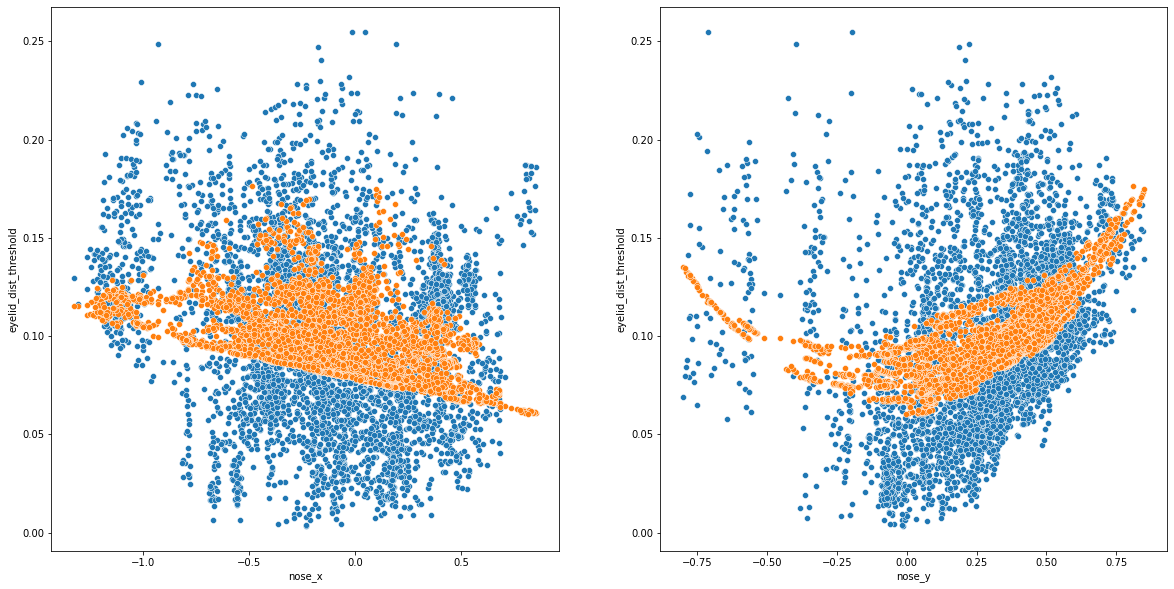

In [62]:
results = smf.ols('eyelid_dist_threshold ~ nose_x +  nose_y  + np.exp(nose_y**2) - 1', data = data).fit()
draw_stats_result(train_blinking_df, data, results, 'eyelid_dist_threshold')
results.summary2()

Mean Squared Error of Threshold Regression: 0.00130479035729385
F1 Score: 0.5678627145085803
Accuracy: 0.9763672041634672
Precision: 0.5126760563380282
Recall: 0.6363636363636364
ROC AUC Score: 0.8106173232102397


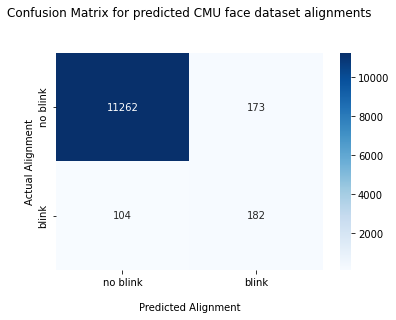

In [80]:
draw_dist_ols_confusion(results)

## Eye Aspect Ratio (EAR) with Adaptive Threshold

### Read Training data and Evaluation Data

In [ ]:
train_df = pd.read_csv('train_rtbene_coors.csv', index_col = 0)
train_blinking_df = train_df[train_df.is_blinking == 1.0]
eval_df = pd.read_csv('test_rtbene_coors.csv', index_col = 0)

### EAR related methods

In [ ]:
def eval_ear(df):
  vert_1 = get_distance(df, 158, 153)
  vert_2 = get_distance(df, 160, 144)
  hor = get_distance(df, 33, 133)
  eye_aspect = (vert_1 + vert_2) / (2 * hor)
  nose_coors = get_point(df, 1)
  data = pd.DataFrame(
      data = {
          'ear_threshold': eye_aspect,
          'nose_x': nose_coors[nose_coors.columns[0]],
          'nose_y': nose_coors[nose_coors.columns[1]],
      }
  )
  return data

def draw_ear_ols_confusion(results, offset = 0.0):
  eval_data = eval_ear(eval_df)
  eval_data['threshold'] = results.predict(eval_data) + offset
  eval_data['is_blinking'] = (eval_data.ear_threshold < (eval_data.threshold)).astype(float)
  valid_idx = eval_df['is_blinking'] != 0.5
  # metrics.confusion_matrix(eval_processed_df[valid_idx].is_blinking, eval_data[valid_idx].is_blinking, labels = [0.0, 1.0])
  labels = [0.0, 1.0]
  labels_2 = ['no blink', 'blink']
  y, y_cap = eval_df[valid_idx].is_blinking, eval_data[valid_idx].is_blinking

  print(f'F1 Score: {metrics.f1_score(y, y_cap)}')
  print(f'Accuracy: {metrics.accuracy_score(y, y_cap)}')
  print(f'Precision: {metrics.precision_score(y, y_cap)}')
  print(f'Recall: {metrics.recall_score(y, y_cap)}')
  print(f'ROC AUC Score: {metrics.roc_auc_score(y, y_cap)}')

  cf_matrix = metrics.confusion_matrix(y, y_cap, labels = labels)
  ax = sns.heatmap(cf_matrix, annot=True, 
              fmt='2', cmap='Blues')

  ax.set_title('Confusion Matrix for predicted CMU face dataset alignments\n\n');
  ax.set_xlabel('\nPredicted Alignment')
  ax.set_ylabel('Actual Alignment');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(labels_2)
  ax.yaxis.set_ticklabels(labels_2)

### Evaluate

-0.019692620372541235


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Ordinary least squares
=================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.854      
Dependent Variable:     ear_threshold    AIC:                         -14194.0266
Date:                   2023-01-26 03:40 BIC:                         -14168.0280
No. Observations:       4913             Log-Likelihood:              7101.0     
Df Model:               4                F-statistic:                 7205.      
Df Residuals:           4909             Prob (F-statistic):          0.00       
R-squared (uncentered): 0.854            Scale:                       0.0032543  
-----------------------------------------------------------------------------------
                          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-----------------------------------------------------------------------------------
nose_y                   -0.0135     0.0037    -3.6267   0.0003   -0.0209   -0.0062
I(nose_y ** 2)            0.1202     0.0069    17.3599   0.0000    0.1066    0.1338
nose_x                   -0.0487     0.0022   -21.9649   0.0000   -0.0531   -0.0444
np.exp(nose_x ** 2)       0.0821     0.0009    88.7911   0.0000    0.0803    0.0839
---------------------------------------------------------------------------------
Omnibus:                 2256.508           Durbin-Watson:              0.484    
Prob(Omnibus):           0.000              Jarque-Bera (JB):           27095.839
Skew:                    1.875              Prob(JB):                   0.000    
Kurtosis:                13.876             Condition No.:              13       
=================================================================================

"""

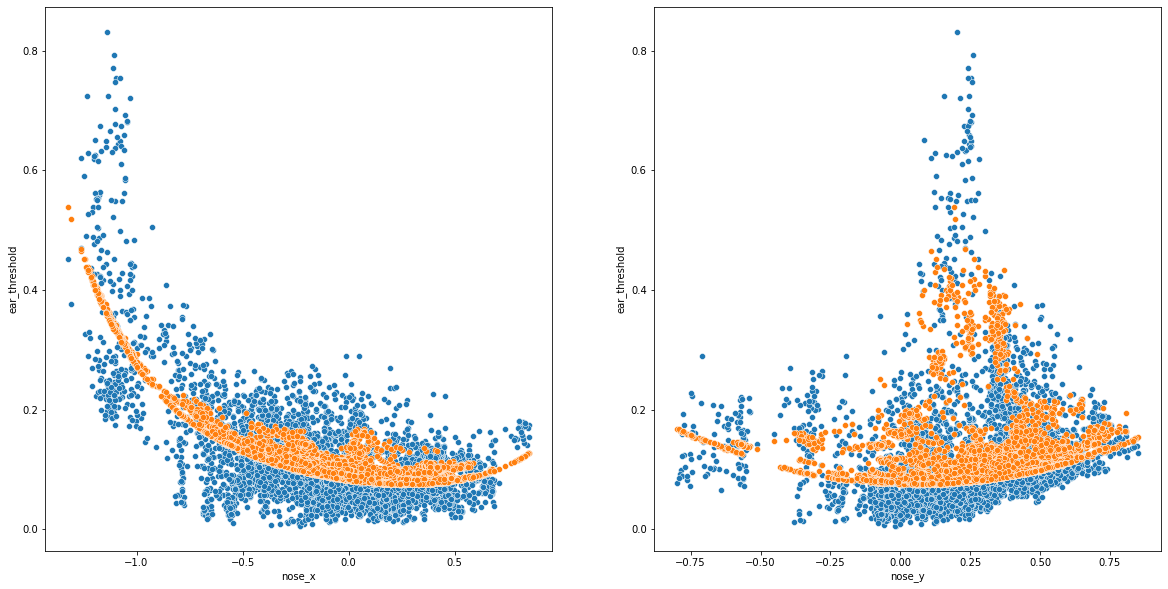

In [ ]:
train_data = eval_ear(train_blinking_df)
results = smf.ols('ear_threshold ~ nose_y + I(nose_y**2)  + nose_x + np.exp(nose_x ** 2) - 1', data = train_data).fit()
draw_stats_result(train_blinking_df, train_data, results, 'ear_threshold')
results.summary2()

F1 Score: 0.5185185185185185
Accuracy: 0.9711628700622814
Precision: 0.4375
Recall: 0.6363636363636364
ROC AUC Score: 0.8079500735381802


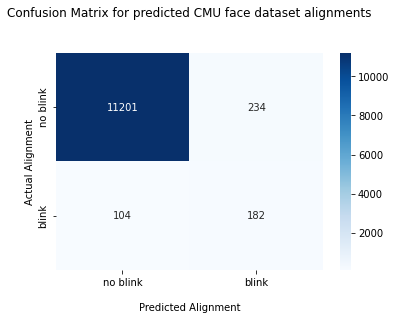

In [ ]:
draw_ear_ols_confusion(results)

## EAR with Constant Threshold

In [ ]:
train_df = pd.read_csv('train_rtbene_candid_coors.csv', index_col = 0)
train_blinking_df = train_df[train_df.is_blinking == 1.0]
eval_df = pd.read_csv('test_rtbene_candid_coors.csv', index_col = 0)

F1 Score: 0.24641148325358853
Accuracy: 0.892335298641374
Precision: 0.14862914862914864
Recall: 0.7202797202797203
ROC AUC Score: 0.8084625368500293


[Text(0, 0.5, 'no blink'), Text(0, 1.5, 'blink')]

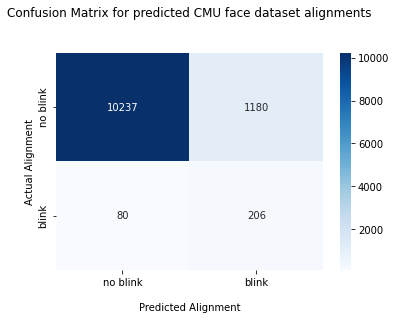

In [ ]:
eval_data = eval_ear(eval_df)
### Constant Threshold
eval_data['threshold'] = 0.2
eval_data['is_blinking'] = (eval_data.ear_threshold < (eval_data.threshold)).astype(float)
valid_idx = eval_df['is_blinking'] != 0.5

y, y_cap = eval_df[valid_idx].is_blinking, eval_data[valid_idx].is_blinking

print(f'F1 Score: {metrics.f1_score(y, y_cap)}')
print(f'Accuracy: {metrics.accuracy_score(y, y_cap)}')
print(f'Precision: {metrics.precision_score(y, y_cap)}')
print(f'Recall: {metrics.recall_score(y, y_cap)}')
print(f'ROC AUC Score: {metrics.roc_auc_score(y, y_cap)}')

# metrics.confusion_matrix(eval_processed_df[valid_idx].is_blinking, eval_data[valid_idx].is_blinking, labels = [0.0, 1.0])
labels = [0.0, 1.0]
labels_2 = ['no blink', 'blink']
cf_matrix = metrics.confusion_matrix(y, y_cap, labels = labels)
ax = sns.heatmap(cf_matrix, annot=True, 
            fmt='2', cmap='Blues')

ax.set_title('Confusion Matrix for predicted CMU face dataset alignments\n\n');
ax.set_xlabel('\nPredicted Alignment')
ax.set_ylabel('Actual Alignment');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(labels_2)
ax.yaxis.set_ticklabels(labels_2)

## Eyeblink8 and TalkingFace

In [ ]:
# install imutils
!pip install imutils

!pip install mediapipe

# import packages
from scipy.spatial import distance as dist
import imutils
from imutils import face_utils
import numpy as np
import pandas as pd
import cv2
import os
import time
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, roc_auc_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline

import mediapipe as mp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p input
!wget -O input/eyeblin8.zip https://www.blinkingmatters.com/files/upload/research/eyeblink8.zip
!wget -O input/talkingFace.zip https://www.blinkingmatters.com/files/upload/research/talkingFace.zip
!unzip -o input/talkingFace.zip -d input/
!unzip -o input/eyeblin8.zip -d input/

--2023-01-26 02:31:27--  https://www.blinkingmatters.com/files/upload/research/eyeblink8.zip
Resolving www.blinkingmatters.com (www.blinkingmatters.com)... 46.28.105.86, 2a02:2b88:1:4::38
Connecting to www.blinkingmatters.com (www.blinkingmatters.com)|46.28.105.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 312670860 (298M) [application/zip]
Saving to: ‘input/eyeblin8.zip’

input/eyeblin8.zip  100%[===================>] 298.19M  27.5MB/s    in 12s     

2023-01-26 02:31:39 (25.5 MB/s) - ‘input/eyeblin8.zip’ saved [312670860/312670860]

--2023-01-26 02:31:40--  https://www.blinkingmatters.com/files/upload/research/talkingFace.zip
Resolving www.blinkingmatters.com (www.blinkingmatters.com)... 46.28.105.86, 2a02:2b88:1:4::38
Connecting to www.blinkingmatters.com (www.blinkingmatters.com)|46.28.105.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21010855 (20M) [application/zip]
Saving to: ‘input/talkingFace.zip’

input/talkingFace.

In [ ]:
# print content of any folder
def display_folder(path):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            print(os.path.join(dirname, filename))
# print content of "../input" folder
display_folder("./input")

./input/talkingFace.zip
./input/eyeblin8.zip
./input/eyeblink8/2/26122013_224532_cam.avi
./input/eyeblink8/2/26122013_224532_cam.tag
./input/eyeblink8/2/26122013_224532_cam.txt
./input/eyeblink8/4/26122013_230654_cam.avi
./input/eyeblink8/4/26122013_230654_cam.tag
./input/eyeblink8/4/26122013_230654_cam.txt
./input/eyeblink8/3/26122013_230103_cam.txt
./input/eyeblink8/3/26122013_230103_cam.tag
./input/eyeblink8/3/26122013_230103_cam.avi
./input/eyeblink8/11/27122013_154548_cam.avi
./input/eyeblink8/11/27122013_154548_cam.txt
./input/eyeblink8/11/27122013_154548_cam.tag
./input/eyeblink8/8/27122013_151644_cam.tag
./input/eyeblink8/8/27122013_151644_cam.txt
./input/eyeblink8/8/27122013_151644_cam.avi
./input/eyeblink8/9/27122013_152435_cam.txt
./input/eyeblink8/9/27122013_152435_cam.tag
./input/eyeblink8/9/27122013_152435_cam.avi
./input/eyeblink8/1/26122013_223310_cam.txt
./input/eyeblink8/1/26122013_223310_cam.avi
./input/eyeblink8/1/26122013_223310_cam.tag
./input/eyeblink8/10/2712201

In [ ]:
def get_distance(p1, p2):
  return np.sqrt(np.square(p1 - p2).sum(axis = 0))

def eval_left_ear(landmarks):
  vert_1 = get_distance(landmarks[158], landmarks[153])
  vert_2 = get_distance(landmarks[160], landmarks[144])
  hor = get_distance(landmarks[33], landmarks[133])
  return (vert_1 + vert_2) / (2 * hor)

def eval_right_ear(landmarks):
  vert_1 = get_distance(landmarks[387], landmarks[373])
  vert_2 = get_distance(landmarks[385], landmarks[380])
  hor = get_distance(landmarks[362], landmarks[263])
  return (vert_1 + vert_2) / (2 * hor)

def eval_left_eld(landmarks):
  return get_distance(landmarks[159], landmarks[145])

def eval_right_eld(landmarks):
  return get_distance(landmarks[386], landmarks[374])

def eval_face_orientation(landmarks):
  return landmarks[1][0], landmarks[1][1]

def landmarks_decor(func):
  def wrapper(landmarks, width, height):
    landmarks = landmarks.landmark
    xs = np.array([landmark.x for landmark in landmarks])
    ys = np.array([landmark.y for landmark in landmarks])
    zs = np.array([landmark.z for landmark in landmarks])
    return func(xs, ys, zs, width, height)
  return wrapper

@landmarks_decor
def candid_ear_model(xs, ys, zs, width, height):
  candid_xs = xs * width
  candid_ys = ys * height
  landmarks = np.stack([candid_xs, candid_ys], axis = 1)
  leftEAR = eval_left_ear(landmarks)
  rightEAR = eval_right_ear(landmarks)
  ear = (leftEAR + rightEAR) / 2.0
  return int(ear < 0.2), int(leftEAR < 0.2), int(rightEAR < 0.2), ear, leftEAR, rightEAR

@landmarks_decor
def adaptive_eld_model(xs, ys, zs, _, __):
  std_xs = (xs - xs.mean()) / xs.std()
  std_ys = (ys - ys.mean()) / ys.std()
  std_zs = (zs - zs.mean()) / zs.std()
  landmarks = np.stack([std_xs, std_ys], axis = 1)
  o_x, o_y = eval_face_orientation(landmarks)
  
  leftELD = eval_left_eld(landmarks)
  rightELD = eval_right_eld(landmarks)
  eld = (leftELD + rightELD) / 2.0

  threshold = (-0.0228 * o_x) + (0.0162 * o_y) + (0.0792 * np.exp(np.square(o_y)))
  return int(eld < threshold), int(leftELD < threshold), int(rightELD < threshold), eld, leftELD, rightELD

@landmarks_decor
def adaptive_ear_model(xs, ys, zs, width, height):
  std_xs = (xs - xs.mean()) / xs.std()
  std_ys = (ys - ys.mean()) / ys.std()
  std_zs = (zs - zs.mean()) / zs.std()
  landmarks = np.stack([std_xs, std_ys], axis = 1)
  o_x, o_y = eval_face_orientation(landmarks)

  leftEAR = eval_left_ear(landmarks)
  rightEAR = eval_right_ear(landmarks)
  threshold = (-0.0487 * o_x) + (0.0821 * np.exp(np.square(o_x))) + (-0.0135 * o_y) + (0.1202 * np.square(o_y))
  ear = (leftEAR + rightEAR) / 2.0
  return int(ear < threshold), int(leftEAR < threshold), int(rightEAR < threshold), ear, leftEAR, rightEAR

In [ ]:
mp_face_mesh = mp.solutions.face_mesh

# process a given video file 
def process_video(input_file, model, skip_n=0, up_to = None):
    #define necessary variables
    TOTAL = 0
    current_frame = 0
    closeness = 0
    avg_closeness = []
    le_closeness = []
    re_closeness = []
    output_blinks = []
    blink_info = (0,0)
    processed_frames = []
    frame_info_list = []

    #define capturing method
    cap = cv2.VideoCapture(input_file)
    time.sleep(1.0)
    
    #build a dictionary video_info
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int( cap.get(cv2.CAP_PROP_FRAME_COUNT) )
    duration = frame_count / fps
    video_info_dict = {
        'fps': fps,
        'frame_count': frame_count,
        'duration(s)': duration,
    }
    with mp_face_mesh.FaceMesh(
      max_num_faces=1,
      refine_landmarks=True,
      min_detection_confidence=0.5) as face_mesh:
      while True:
        # grab the frame from the threaded video file stream, resize
        # it, and convert it to grayscale
        # channels)
        (grabbed, frame) = cap.read()
        if not grabbed:
            break
        height = frame.shape[0]
        width = frame.shape[1]
        frame = cv2.resize(frame, (480, int(480*height/width)))
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb)
        if results.multi_face_landmarks == None:
          frame_info={
              'frame_no': current_frame,
              'face_detected': False,
              'left_met': -1, 
              'right_met': -1,
              'avg_met': -1, 
              'avg_closeness': -1,
              'left_closeness': -1,
              'right_closeness': -1,
              'reserved_for_calibration': False
          }
          frame_info_list.append(frame_info)
          continue
        for face_landmarks in results.multi_face_landmarks:
          avg_closeness_, le_closeness_, re_closeness_, avg_met, le_met, re_met = model(face_landmarks, width, height)

          avg_closeness.append(avg_closeness_)
          le_closeness.append(le_closeness_)
          re_closeness.append(re_closeness_)

          # draw the total number of blinks on the frame along with
          # the computed eye aspect ratio for the frame
          # cv2.putText(frame, "Blinks: {}".format(TOTAL), (10, 30),
          #     cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
          # cv2.putText(frame, "Met: {:.2f}".format(avg_met), (300, 30),
          #     cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
          # build frame_info dictionary then add to listy
          frame_info={
                  'frame_no': current_frame,
                  'face_detected': results.multi_face_landmarks and len(results.multi_face_landmarks) > 0,
                  'left_met': le_met, 
                  'right_met': re_met,
                  'avg_met': avg_met, 
                  'avg_closeness': avg_closeness_,
                  'left_closeness': le_closeness_,
                  'right_closeness': re_closeness_,
                  'reserved_for_calibration': False
              }
          frame_info_list.append(frame_info)

        #append processed frame to list
        current_frame += 1
        frame_info_df = pd.DataFrame(frame_info_list) #build a dataframe from frame_info_list
        if up_to==current_frame-1:
            break

    # a bit of clean-up
    cv2.destroyAllWindows()
    cap.release()
    
    # print status
    file_name = os.path.basename(input_file)
    output_str = "Processing {} has done.\n\n".format(file_name)
    print(output_str)

    # update 'reserved_for_calibration' column of frame_info_df for first "skip_n" frames
    frame_info_df.loc[:skip_n-1, 'reserved_for_calibration'] = True # .loc includes second index -> [first:second]
    frame_info_df = frame_info_df.set_index('frame_no')
    return frame_info_df, avg_closeness[skip_n:], le_closeness[skip_n:], re_closeness[skip_n:], video_info_dict, output_str

In [ ]:
# read tag file and construct "closeness_list" and "blinks_list"
def read_annotations(input_file, skip_n = 0):
    # define variables 
    blink_start = 1
    blink_end = 1
    blink_info = (0,0)
    blink_list = []
    closeness_list = []
    le_closeness_list = []
    re_closeness_list = []
    frames = []

    # Using readlines() 
    file1 = open(input_file)
    Lines = file1.readlines() 

    # find "#start" line 
    start_line = 1
    for line in Lines: 
        clean_line=line.strip()
        if clean_line=="#start":
            break
        start_line += 1

    # convert tag file to readable format and build "closeness_list" and "blink_list"
    for index in range(len(Lines[start_line+skip_n : -1])): # -1 since last line will be"#end"
        
        # read previous annotation and current annotation 
        prev_annotation=Lines[start_line+skip_n+index-1].split(':')
        current_annotation=Lines[start_line+skip_n+index].split(':')
        
        # if previous annotation is not "#start" line and not "blink" and current annotation is a "blink"
        if prev_annotation[0] != "#start\n" and prev_annotation[1] == "-1" and int(current_annotation[1]) > 0:
            # it means a new blink starts so save frame id as starting frame of the blink
            blink_start = int(current_annotation[0])
        
        # if previous annotation is not "#start" line and is a "blink" and current annotation is not a "blink"
        if prev_annotation[0] != "#start\n" and int(prev_annotation[1]) > 0 and current_annotation[1] == "-1":
            # it means a new blink ends so save (frame id - 1) as ending frame of the blink
            blink_end = int(current_annotation[0]) - 1
            # and construct a "blink_info" tuple to append the "blink_list"
            blink_info = (blink_start,blink_end)
            blink_list.append(blink_info)
        
        frames.append(int(current_annotation[0]))
        le_closeness_list.append(1 if current_annotation[3] == "C" else 0)
        re_closeness_list.append(1 if current_annotation[5] == "C" else 0)

        # if current annotation consist fully closed eyes, append it also to "closeness_list" 
        if current_annotation[3] == "C" and current_annotation[5] == "C":
            closeness_list.append(1)
        else:
            closeness_list.append(0)
    
    file1.close()

    return pd.DataFrame(
        data = {
            'avg_gt': closeness_list,
            'le_gt': le_closeness_list,
            're_gt': re_closeness_list,
        },
        index=frames
    )

In [ ]:
def process_dir(path, model):
  base_filename = os.listdir(path)[0].split('.')[0]
  
  video_file = os.path.join(path, f'{base_filename}.avi') 
  tag_file = os.path.join(path, f'{base_filename}.tag')

  annotation_df = read_annotations(tag_file, skip_n = 0)
  # process the video and get the results
  frame_info_df, avg_closeness, le_closeness, re_closeness, video_info, scores_string \
    = process_video(video_file, model = model, skip_n=0)
  df = pd.merge(frame_info_df, annotation_df, left_index=True, right_index=True)
  df = df[df.face_detected]
  closeness_gt = [*df.le_gt, *df.re_gt]
  closeness_pt = [*df.left_closeness, *df.right_closeness]
  return closeness_gt, closeness_pt

def process_dirs(paths, model):
  closeness_gt = []
  closeness_pt = []
  for subdir in paths:
    gt, pt = process_dir(subdir, model)
    closeness_gt.extend(gt)
    closeness_pt.extend(pt)
  
  return closeness_gt, closeness_pt

In [ ]:
def print_results(gt, pt):
  print(f'Accuracy: {accuracy_score(gt, pt)}')
  print(f'F1: {f1_score(gt, pt)}')
  print(f'Precision: {precision_score(gt, pt)}')
  print(f'Recall: {recall_score(gt, pt)}')
  print(f'ROC-AUC: {roc_auc_score(gt, pt)}')
  print('-------------------')
  print('Confusion Matrix')
  print('-------------------')
  print(confusion_matrix(gt, pt))

In [ ]:
np.random.seed(7)

eb8_path = './input/eyeblink8' 
# n_samples = 4

# Lets not cherrypick
n_samples = 8
paths = np.random.choice([os.path.join(eb8_path, dir) for dir in os.listdir(eb8_path)], n_samples).tolist()

eyeblink8_gt, aear_pt = process_dirs(paths, adaptive_ear_model)
_, aeld_pt = process_dirs(paths, adaptive_eld_model)
_, cear_pt = process_dirs(paths, candid_ear_model)

Processing 26122013_223310_cam.avi has done.


Processing 27122013_154548_cam.avi has done.


Processing 27122013_154548_cam.avi has done.


Processing 27122013_153916_cam.avi has done.


Processing 27122013_153916_cam.avi has done.


Processing 27122013_153916_cam.avi has done.


Processing 27122013_151644_cam.avi has done.


Processing 26122013_230654_cam.avi has done.


Processing 26122013_223310_cam.avi has done.


Processing 27122013_154548_cam.avi has done.


Processing 27122013_154548_cam.avi has done.


Processing 27122013_153916_cam.avi has done.


Processing 27122013_153916_cam.avi has done.




In [ ]:
print_results(eyeblink8_gt, cear_pt)

Accuracy: 0.8480490409796492
F1: 0.10581145071028844
Precision: 0.059489810736240864
Recall: 0.4780241151302995
ROC-AUC: 0.6665828652084238
-------------------
Confusion Matrix
-------------------
[[114701  19430]
 [  1342   1229]]


In [ ]:
print_results(eyeblink8_gt, aeld_pt)

Accuracy: 0.9700516451844158
F1: 0.2634041021950342
Precision: 0.24506193505189153
Recall: 0.2847141190198366
ROC-AUC: 0.6339510981736127
-------------------
Confusion Matrix
-------------------
[[131876   2255]
 [  1839    732]]


In [ ]:
print_results(eyeblink8_gt, aear_pt)

Accuracy: 0.972282775672631
F1: 0.26039430021471793
Precision: 0.26136363636363635
Recall: 0.2594321275768184
ROC-AUC: 0.622689351097085
-------------------
Confusion Matrix
-------------------
[[132246   1885]
 [  1904    667]]


In [ ]:
tf_gt, aear_pt_tf = process_dir('./input/talkingFace', adaptive_ear_model)
_, aeld_pt_tf = process_dir('./input/talkingFace', adaptive_eld_model)
_, cear_pt_tf = process_dir('./input/talkingFace', candid_ear_model)

Processing talking.avi has done.


Processing talking.avi has done.


Processing talking.avi has done.




In [ ]:
print_results(tf_gt, cear_pt_tf)

Accuracy: 0.9474
F1: 0.542608695652174
Precision: 0.3723150357995227
Recall: 1.0
ROC-AUC: 0.9728530140379851
-------------------
Confusion Matrix
-------------------
[[9162  526]
 [   0  312]]


In [ ]:
print_results(tf_gt, aeld_pt_tf)

Accuracy: 0.9815
F1: 0.7631241997439181
Precision: 0.6353944562899787
Recall: 0.9551282051282052
ROC-AUC: 0.9687387516144742
-------------------
Confusion Matrix
-------------------
[[9517  171]
 [  14  298]]


In [ ]:
print_results(tf_gt, aear_pt_tf)

Accuracy: 0.9827
F1: 0.7708609271523179
Precision: 0.6568848758465011
Recall: 0.9326923076923077
ROC-AUC: 0.9585013974464842
-------------------
Confusion Matrix
-------------------
[[9536  152]
 [  21  291]]
